# EBM 2D Toy Example

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from tqdm import tqdm
import torch
from torch import Tensor
from typing import *

In [2]:
data_dim = 2

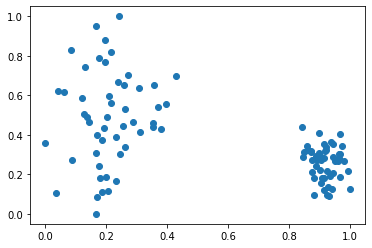

In [3]:
data, _ = make_blobs(n_samples=100, n_features=data_dim, centers=2, cluster_std=(1, 0.4), random_state=7)
data = torch.from_numpy((data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))).float()
plt.scatter(*data.T);

In [4]:
hidden_size = 128

def init_model():
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=data_dim, out_features=hidden_size),
        torch.nn.SiLU(),
        torch.nn.Linear(in_features=hidden_size, out_features=hidden_size),
        torch.nn.SiLU(),
        torch.nn.Linear(in_features=hidden_size, out_features=1))

In [5]:
def unnormalized_p(net, x):
    # exp(-E_theta(x))
    return torch.exp(-net(x))

In [6]:
def plot_all(net, scatter_points=None):
    if scatter_points is None:
        scatter_points = data
    plt.scatter(*scatter_points.T, color='gray', alpha=.3);
    with torch.no_grad():
        rand_points = torch.rand((1000, 2)) * \
            (scatter_points.max(dim=0)[0] - scatter_points.min(dim=0)[0]) + scatter_points.min(dim=0)[0]
        z = unnormalized_p(net, rand_points)
        plt.tricontour(*rand_points.T, z.flatten(), levels=14)

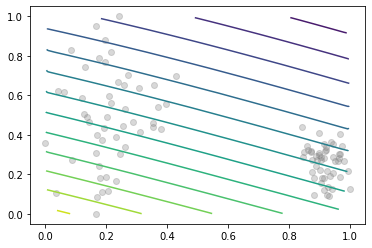

In [7]:
net = init_model()
plot_all(net)

## Inference

In [8]:
ALPHA_START = 1e-2
# This is tricky because we don't want to decay during the Langevin dynamics phase.
ALPHA_END = 1e-2

WARMUP_STEPS = 500
LANGEVIN_SKIPS = 10


def generate(
    energy_fn: Callable[[Tensor], Tensor], num_samples: int, langevin_skips=LANGEVIN_SKIPS
) -> Iterable[np.ndarray]:
    num_langevin_steps = num_samples * langevin_skips
    num_total_steps = num_langevin_steps + WARMUP_STEPS
    
    x_0 = torch.rand(size=(2,))  # same range as the data distribution, [0, 1]
    x_0.requires_grad = True
    alpha_scheduled = np.linspace(ALPHA_START, ALPHA_END, num=num_total_steps)

    x_i = x_0
    for steps in range(num_total_steps):
        eps = torch.randn(x_0.shape) * alpha_scheduled[steps]
        d_energy_dx = torch.autograd.grad(outputs=energy_fn(x_i), inputs=x_i)[0]
        d_energy_dx *= 2  # a little hack here
        x_i = x_i - alpha_scheduled[steps] / 2 * d_energy_dx + eps
        
        in_langevin_phase = steps >= WARMUP_STEPS
        if in_langevin_phase:
            steps_in_langevin_phase = steps - WARMUP_STEPS
            if steps_in_langevin_phase % langevin_skips == 0:
                yield x_i.detach()

In [9]:
NUM_STEPS = 1000
LEARNING_RATE = np.linspace(5e-2, 5e-4, NUM_STEPS)
BATCH_SIZE = 40
MC_SAMPLES = 10
SAMPLER_RESTARTS = 40

energy = init_model()
opt = torch.optim.Adam(params=energy.parameters(), lr=LEARNING_RATE[0])
log = defaultdict(list)

for steps in tqdm(range(NUM_STEPS)):
    opt.param_groups[0]['lr'] = LEARNING_RATE[steps]
    opt.zero_grad()
    
    # left side of Eq. 1 (MCMC)
    x_primes = torch.stack([x for x in generate(energy, MC_SAMPLES) for _ in range(SAMPLER_RESTARTS)])
    logits_mcmc = torch.mean(energy(x_primes))
    log['logits_mcmc'].append(logits_mcmc.detach().numpy())
    
    batch = data[np.random.randint(0, len(data), size=BATCH_SIZE)]
    # right side of Eq. 2 ("normal" model training)
    logits_data = torch.mean(energy(torch.Tensor(batch)))
    log['logits_data'].append(logits_data.detach().numpy())
    
    log_px = (logits_mcmc - logits_data)
    
    (-log_px).backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(energy.parameters(), max_norm=1)
    
    opt.step()

100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 21.04it/s]


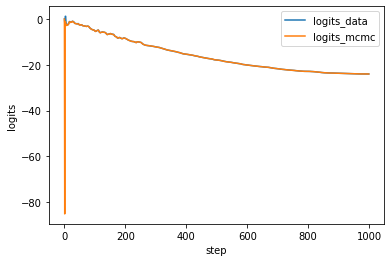

In [10]:
plt.plot(log['logits_data'], label='logits_data')
plt.plot(log['logits_mcmc'], label='logits_mcmc')
plt.xlabel('step')
plt.ylabel('logits')
plt.legend();

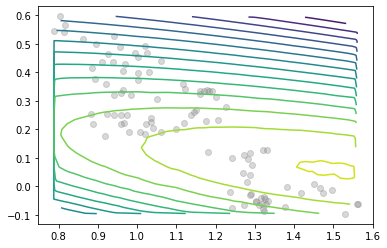

In [11]:
plot_all(energy, torch.stack(tuple(generate(energy, 100))))

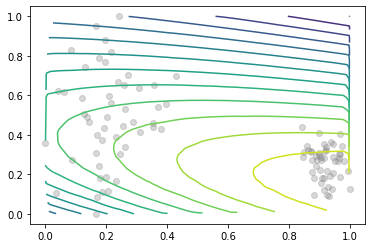

In [12]:
plot_all(energy)

**End of day notes:**

* Try another sampler; ours doesn't follow the gradient that well.
* Scaling up the gradient (and downscaling the noise) had a huge effect.
* Plot everything.
* Decrease the room temperature (it's way too hot here).